First 5 rows of the raw dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------ 

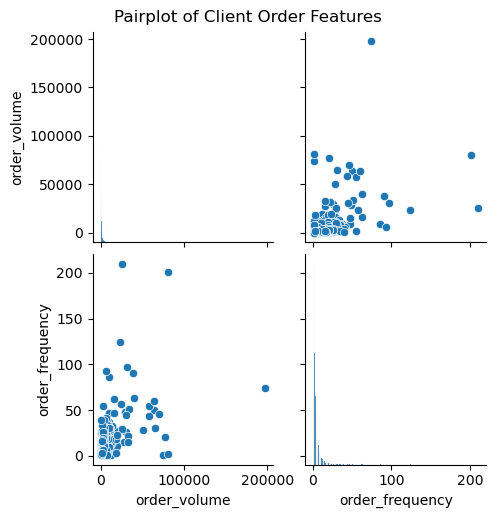

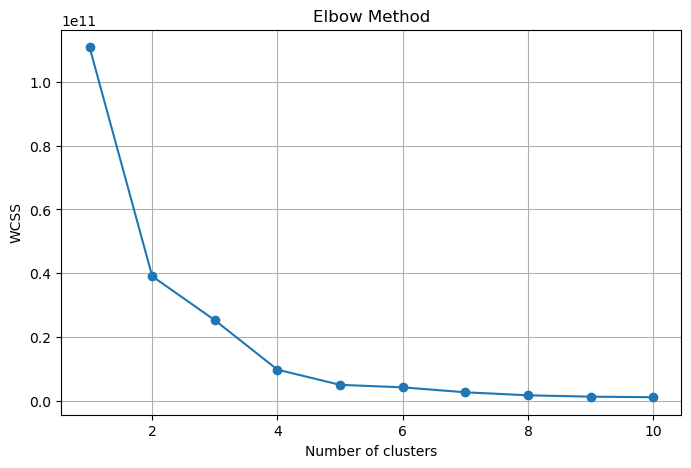


Cluster counts:
cluster
0    4292
1      35
2      12
Name: count, dtype: int64


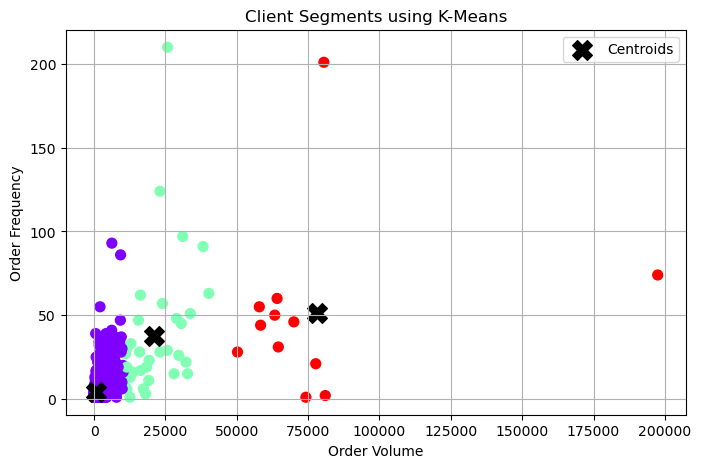

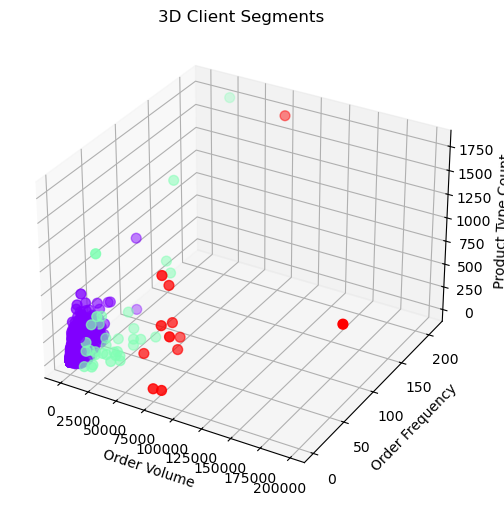

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

df = pd.read_csv('onlineretail.csv', encoding='latin1')
print("First 5 rows of the raw dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

df = df[df['Quantity'] > 0]

df_grouped = df.groupby('CustomerID').agg({
    'Quantity': 'sum',         # total items ordered → order_volume
    'InvoiceNo': 'nunique',    # number of invoices → order_frequency
    'StockCode': 'nunique'     # number of products → product_type_count
}).reset_index()

df_grouped.columns = ['client_id', 'order_volume', 'order_frequency', 'product_type_count']

print("\nFirst 5 rows of cleaned dataset:")
print(df_grouped.head())
print("\nDataset Info:")
print(df_grouped.info())
print("\nStatistical Summary:")
print(df_grouped.describe())

df_grouped.to_csv('customer_orders.csv', index=False)


sns.pairplot(df_grouped[['order_volume', 'order_frequency']])
plt.suptitle("Pairplot of Client Order Features", y=1.02)
plt.show()


X = df_grouped[['order_volume', 'order_frequency']]


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


optimal_clusters = 3  # Adjust based on Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)
df_grouped['cluster'] = y_kmeans

print("\nCluster counts:")
print(df_grouped['cluster'].value_counts())


plt.figure(figsize=(8,5))
plt.scatter(X['order_volume'], X['order_frequency'], c=y_kmeans, cmap='rainbow', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='black', label='Centroids', marker='X')
plt.xlabel('Order Volume')
plt.ylabel('Order Frequency')
plt.title('Client Segments using K-Means')
plt.legend()
plt.grid(True)
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_grouped['order_volume'], df_grouped['order_frequency'], df_grouped['product_type_count'], 
           c=df_grouped['cluster'], cmap='rainbow', s=50)
ax.set_xlabel('Order Volume')
ax.set_ylabel('Order Frequency')
ax.set_zlabel('Product Type Count')
plt.title('3D Client Segments')
plt.show()
